In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm as tqdm
import pickle
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
# Loading data
root_dir = os.getcwd()
start_data_dir = root_dir + '/store-sales-time-series-forecasting'

holiday = pd.read_csv(start_data_dir + '/holidays_events.csv')
oil = pd.read_csv(start_data_dir + '/oil.csv')
stores = pd.read_csv(start_data_dir + '/stores.csv')
transactions = pd.read_csv(start_data_dir + '/transactions.csv')
train = pd.read_csv(start_data_dir + '/train.csv')
test = pd.read_csv(start_data_dir + '/test.csv')

In [3]:
# Holiday preprocess
holiday['transferred'] = holiday['transferred'].map({False: 0, True: 1})
holiday_transferred = holiday[holiday['transferred'] == 1].copy()
true_holiday = holiday[holiday['transferred'] == 0].copy()
true_holiday.drop('transferred', axis=1, inplace=True)

true_holiday['type'].unique()
true_holiday.index = pd.to_datetime(true_holiday['date'])
true_holiday.drop('date', axis=1, inplace=True)
true_holiday.head()

,type,locale,locale_name,description
date,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba


Text(0.5, 1.0, 'Oil price over time')

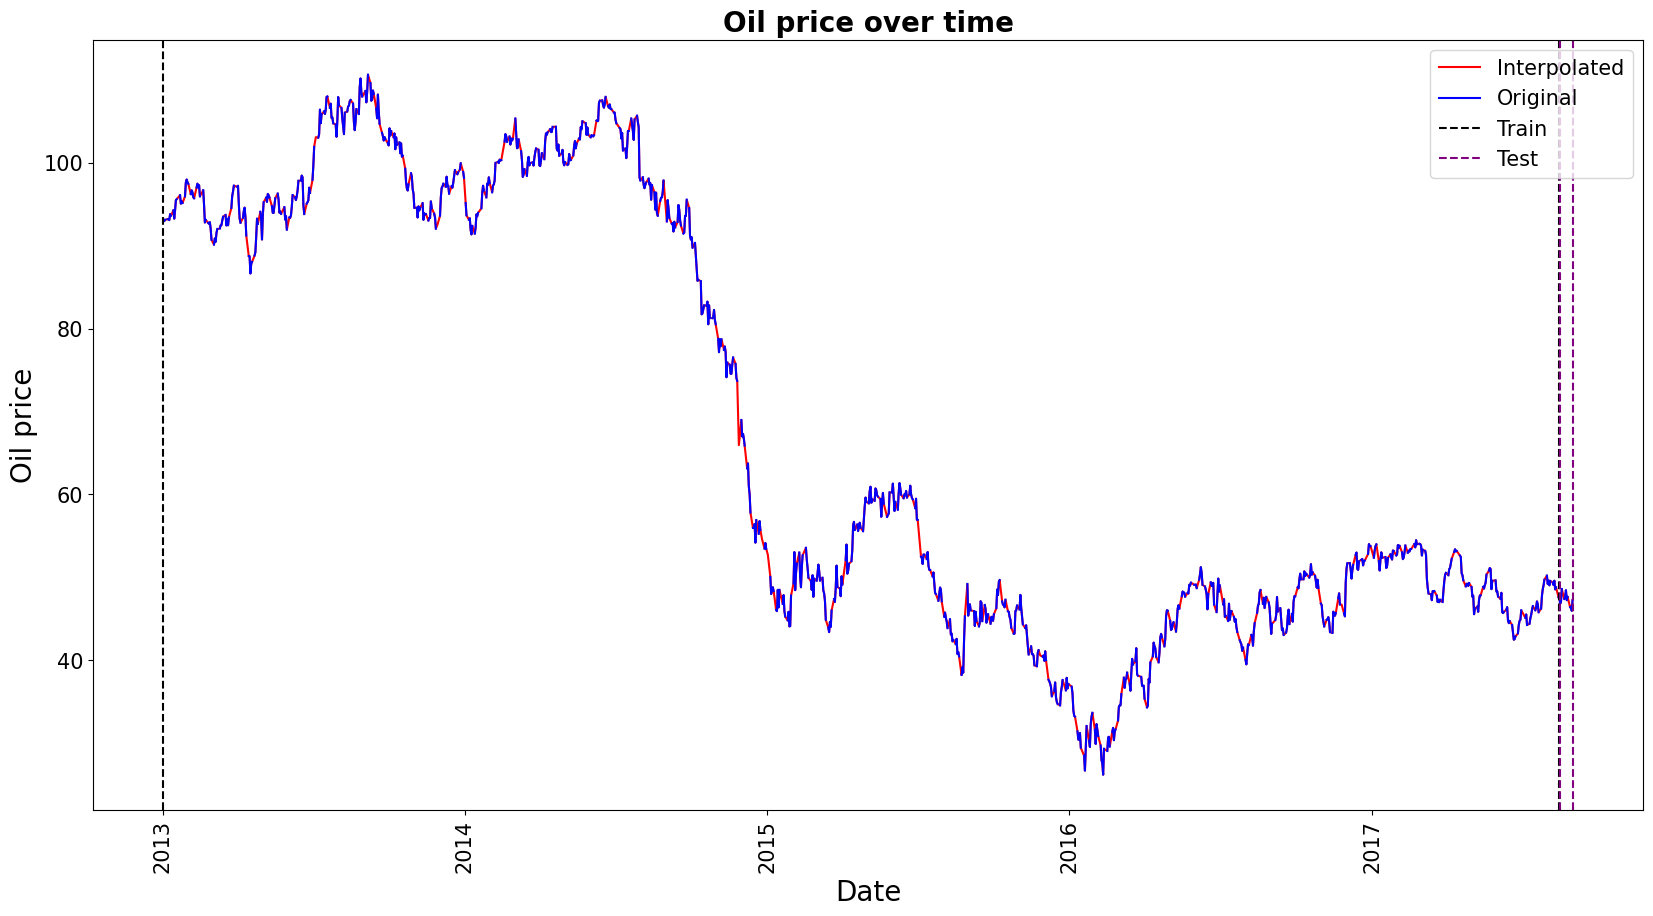

In [4]:
# Oil preprocess
oil_nan = oil[oil['dcoilwtico'].isnull()]
oil.index = pd.to_datetime(oil['date'])
oil.drop('date', axis=1, inplace=True)
oil = oil.reindex(pd.date_range(start=oil.index.min(), end=oil.index.max()))
oil['dcoilwtico_new'] = oil['dcoilwtico'].interpolate(method='linear')

start_date_train = train['date'].min()
end_date_train = train['date'].max()
start_date_test = test['date'].min()
end_date_test = test['date'].max()

# Plot oil price (forse sarà una condizione)
plt.figure(figsize=(20, 10))
plt.plot(oil.index, oil['dcoilwtico_new'], color = 'red', label = 'Interpolated')
plt.plot(oil.index, oil['dcoilwtico'], color = 'blue', label = 'Original')
plt.axvline(x=pd.Timestamp(start_date_train), color='black', linestyle='--', label='Train')
plt.axvline(x=pd.Timestamp(end_date_train), color='black', linestyle='--')
plt.axvline(x=pd.Timestamp(start_date_test), color='purple', linestyle='--', label='Test')
plt.axvline(x=pd.Timestamp(end_date_test), color='purple', linestyle='--')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Oil price', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.title('Oil price over time', fontsize=20, fontweight='bold')

In [5]:
# Transactions
transactions.index = pd.to_datetime(transactions['date'])
transactions.drop('date', axis=1, inplace=True)
len_times_series = {} 
for store in np.sort(transactions['store_nbr'].unique()):
    store_transactions = transactions[transactions['store_nbr'] == store]
    len_times_series[store] = len(store_transactions)

print('Max length of time series:', max(len_times_series.values()), 'for store:', max(len_times_series, key=len_times_series.get))
print('Min length of time series:', min(len_times_series.values()), 'for store:', min(len_times_series, key=len_times_series.get))

# Data 
train.index = pd.to_datetime(train['date'])
train.drop('date', axis=1, inplace=True)
test.index = pd.to_datetime(test['date'])
test.drop('date', axis=1, inplace=True)

Max length of time series: 1678 for store: 26
Min length of time series: 118 for store: 52


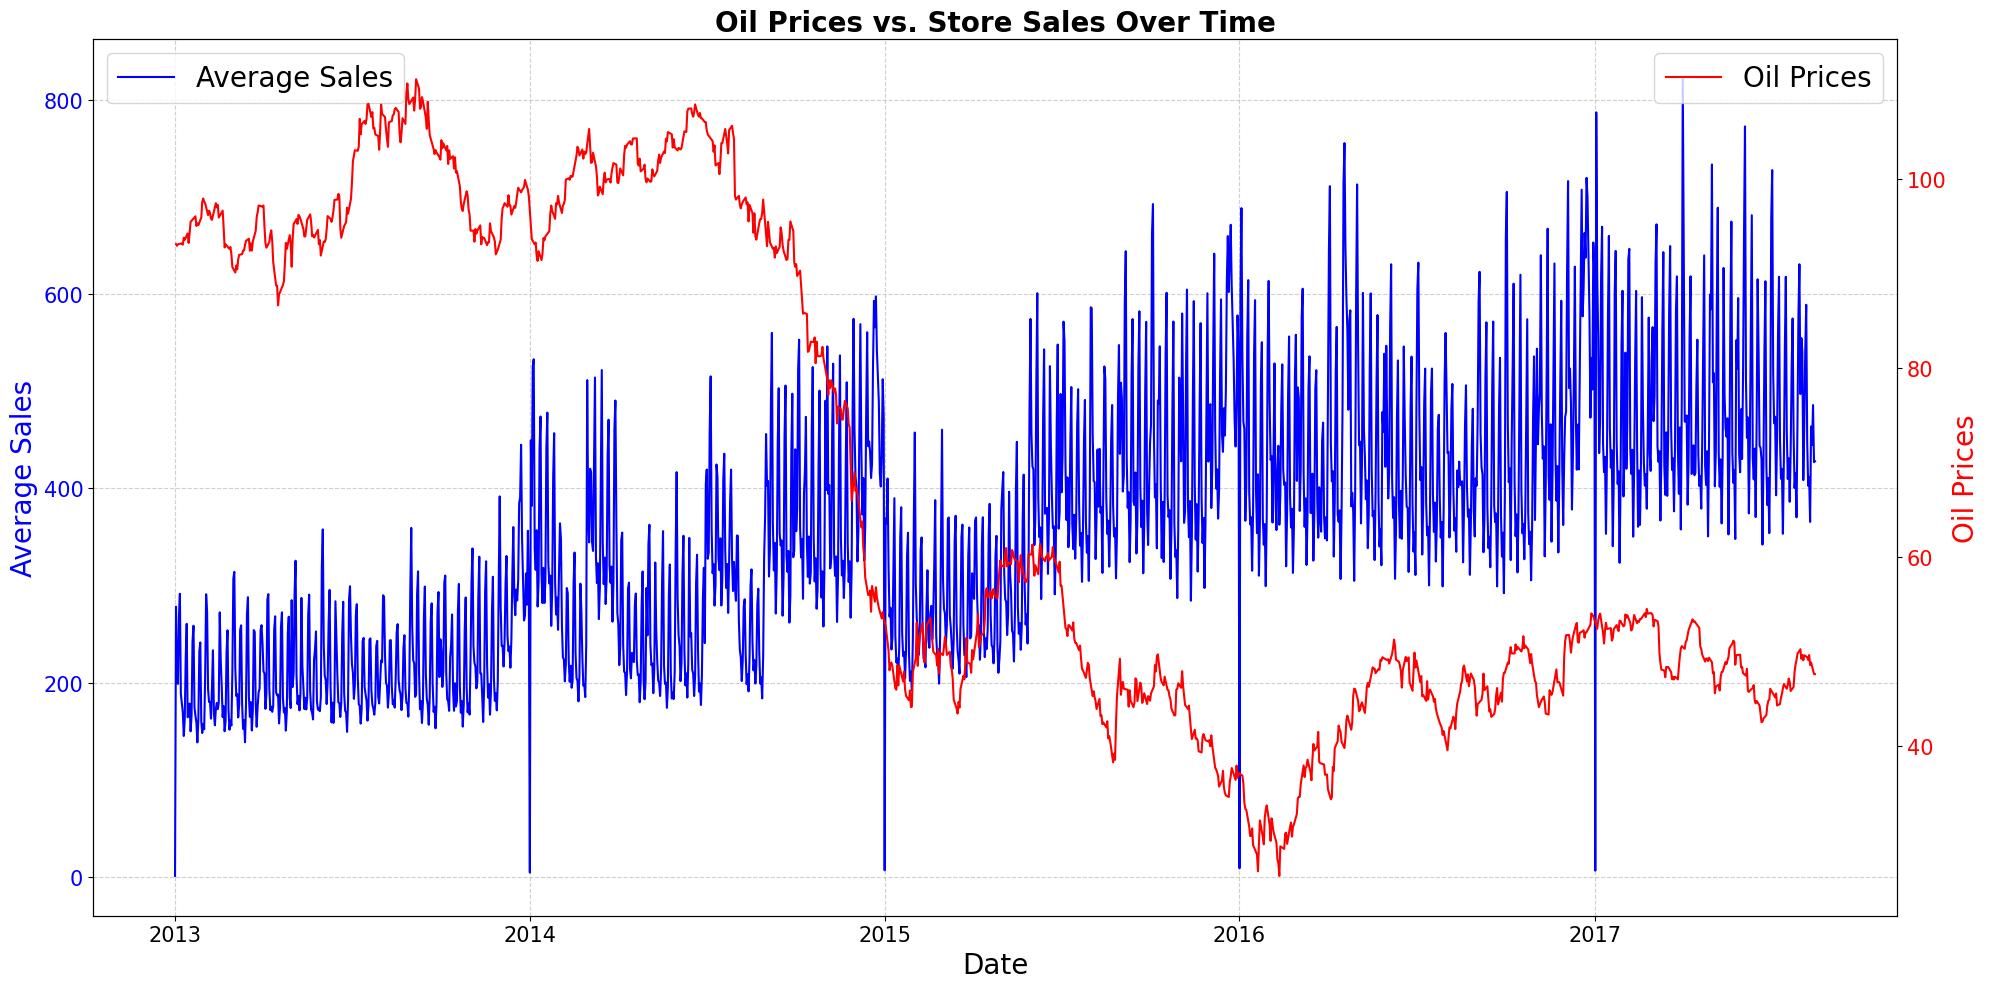

In [6]:
# Comparison plot between sales and oil prices
sales = train.groupby('date')['sales'].mean()
oil_price = oil['dcoilwtico_new']

fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(sales.index, sales.values, color='blue', label='Average Sales')
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Average Sales', fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='both', labelsize=15)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(sales.index, oil_price.loc[sales.index], color='red', label='Oil Prices')  # Allinea le date
ax2.set_ylabel('Oil Prices', fontsize=20, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='both', labelsize=15)

ax1.legend(loc='upper left', fontsize=20, frameon=True)
ax2.legend(loc='upper right', fontsize=20, frameon=True)
plt.title('Oil Prices vs. Store Sales Over Time', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

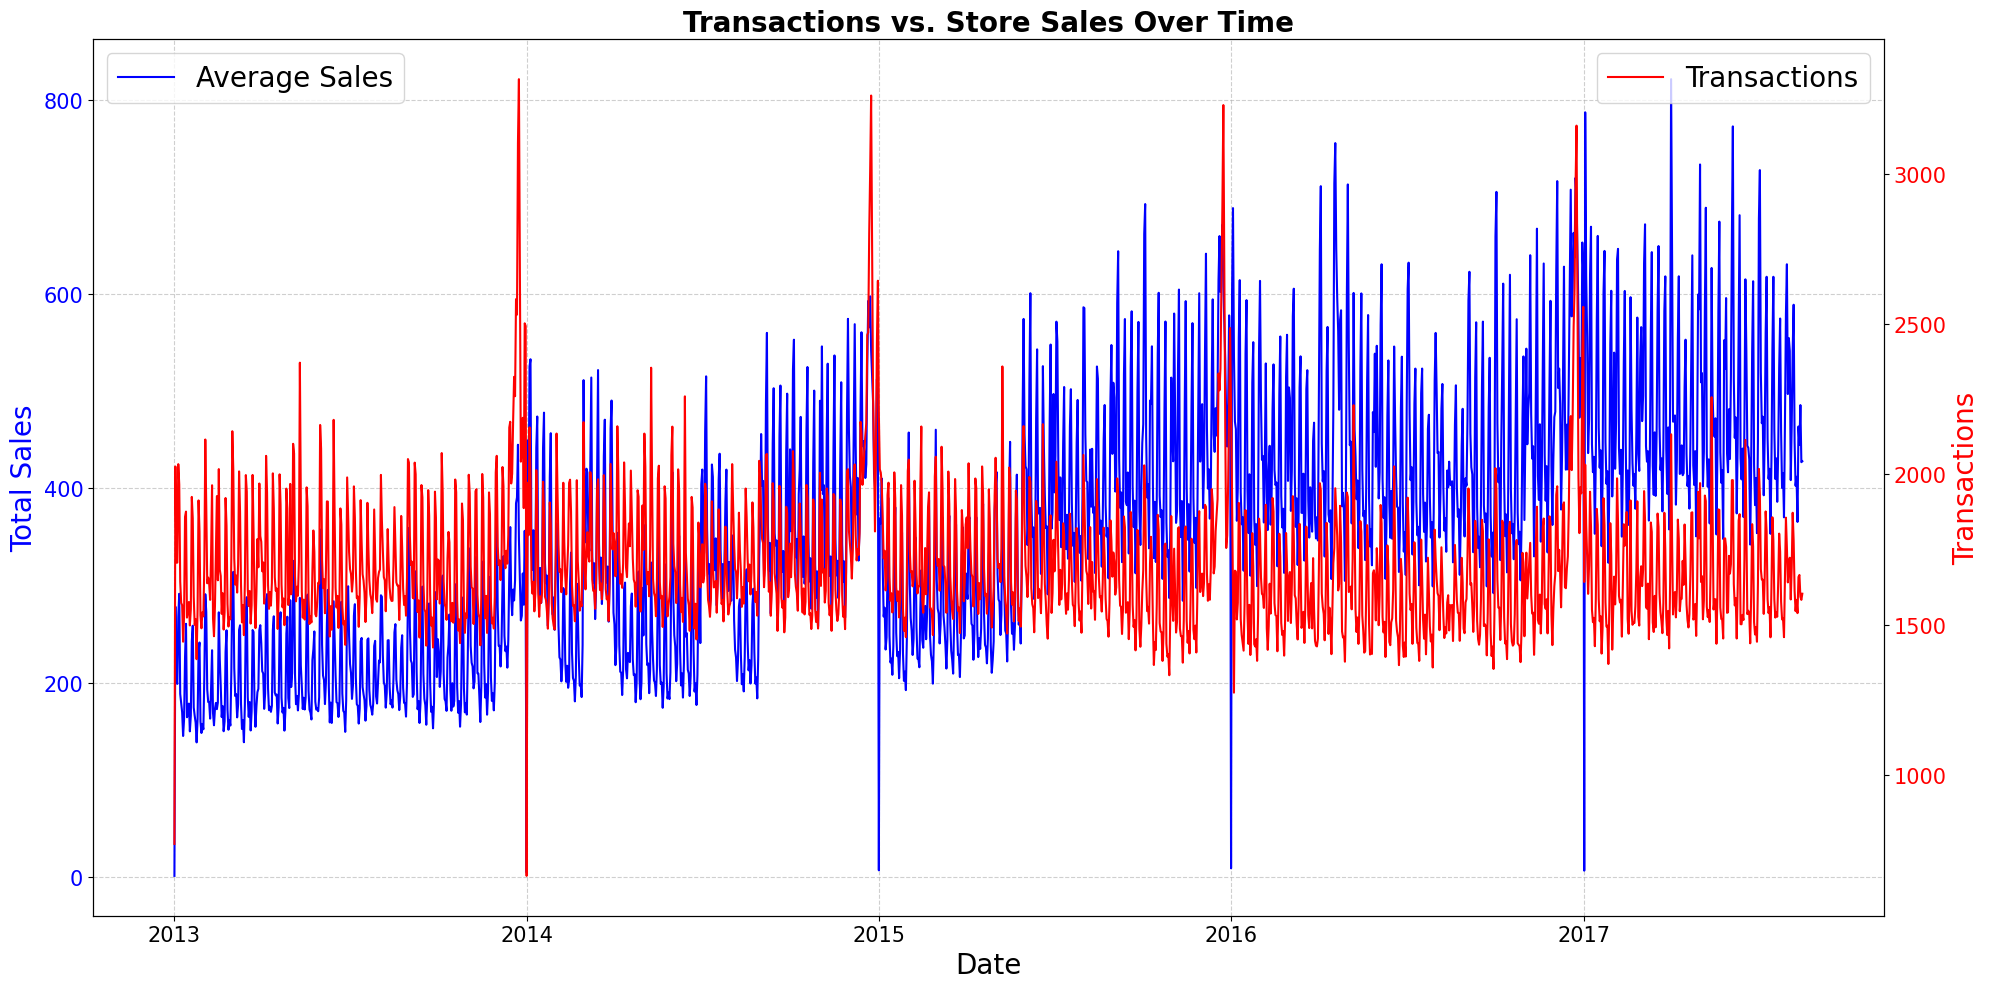

In [7]:
# Comparison plot between sales and transactions
sales = train.groupby('date')['sales'].mean()
trans = transactions.groupby('date')['transactions'].mean()

fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(sales.index, sales.values, color='blue', label='Average Sales')
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Total Sales', fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='both', labelsize=15)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(trans.index, trans.values, color='red', label='Transactions')
ax2.set_ylabel('Transactions', fontsize=20, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='both', labelsize=15)

ax1.legend(loc='upper left', fontsize=20, frameon=True)
ax2.legend(loc='upper right', fontsize=20, frameon=True)

plt.title('Transactions vs. Store Sales Over Time', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

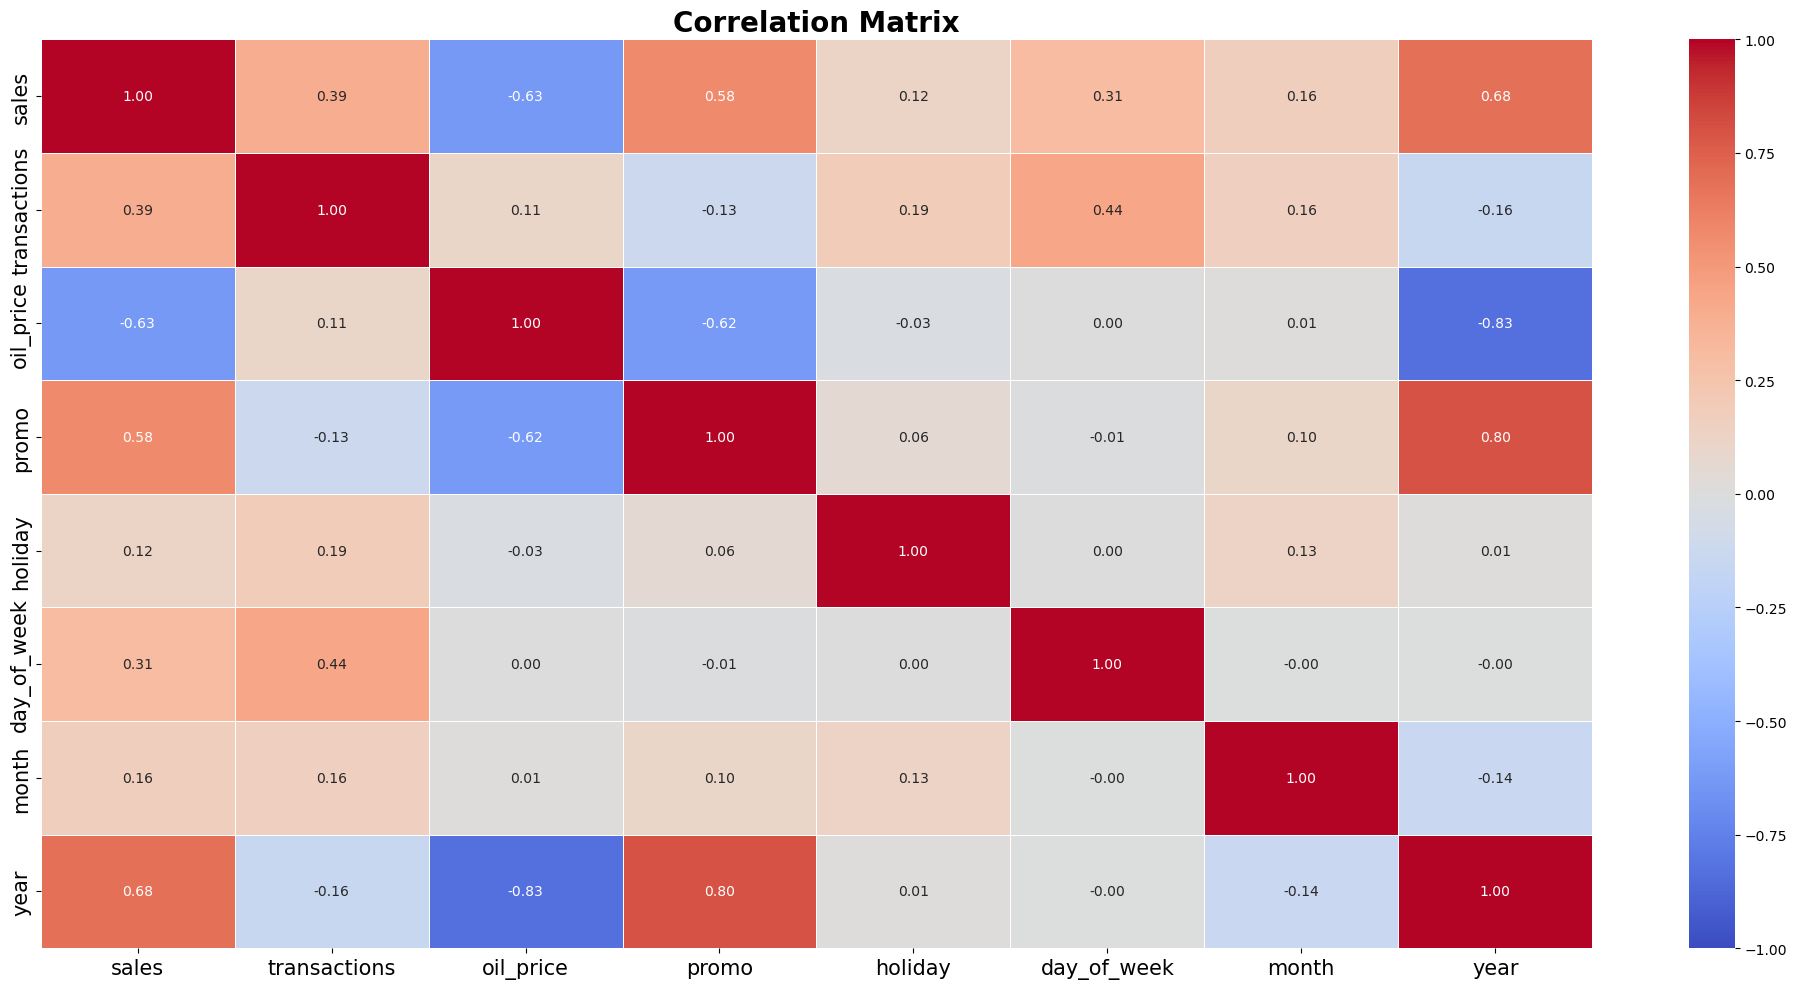

In [8]:
# Correlation plot between sales, transactions and oil price
sales = train.groupby('date')['sales'].mean()
trans = transactions.groupby('date')['transactions'].mean()
promo = train.groupby('date')['onpromotion'].mean()
sales = pd.DataFrame(sales, index=pd.to_datetime(sales.index))
sales['day_of_week'] = sales.index.dayofweek
sales['month'] = sales.index.month
sales['year'] = sales.index.year
true_holidays_dates = true_holiday.index
sales['holiday'] = sales.index.isin(true_holidays_dates).astype(int)

df = pd.DataFrame({
    'sales': sales['sales'],
    'transactions': trans,
    'oil_price': oil_price,
    'promo': promo,
    'holiday': sales['holiday'],
    'day_of_week': sales['day_of_week'],
    'month': sales['month'],
    'year': sales['year']
})
df.dropna(inplace=True)

corr_matrix = df.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize=20, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

/tmp/ipykernel_4837/2262954264.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_weekly.index, y=sales_weekly, palette='viridis')


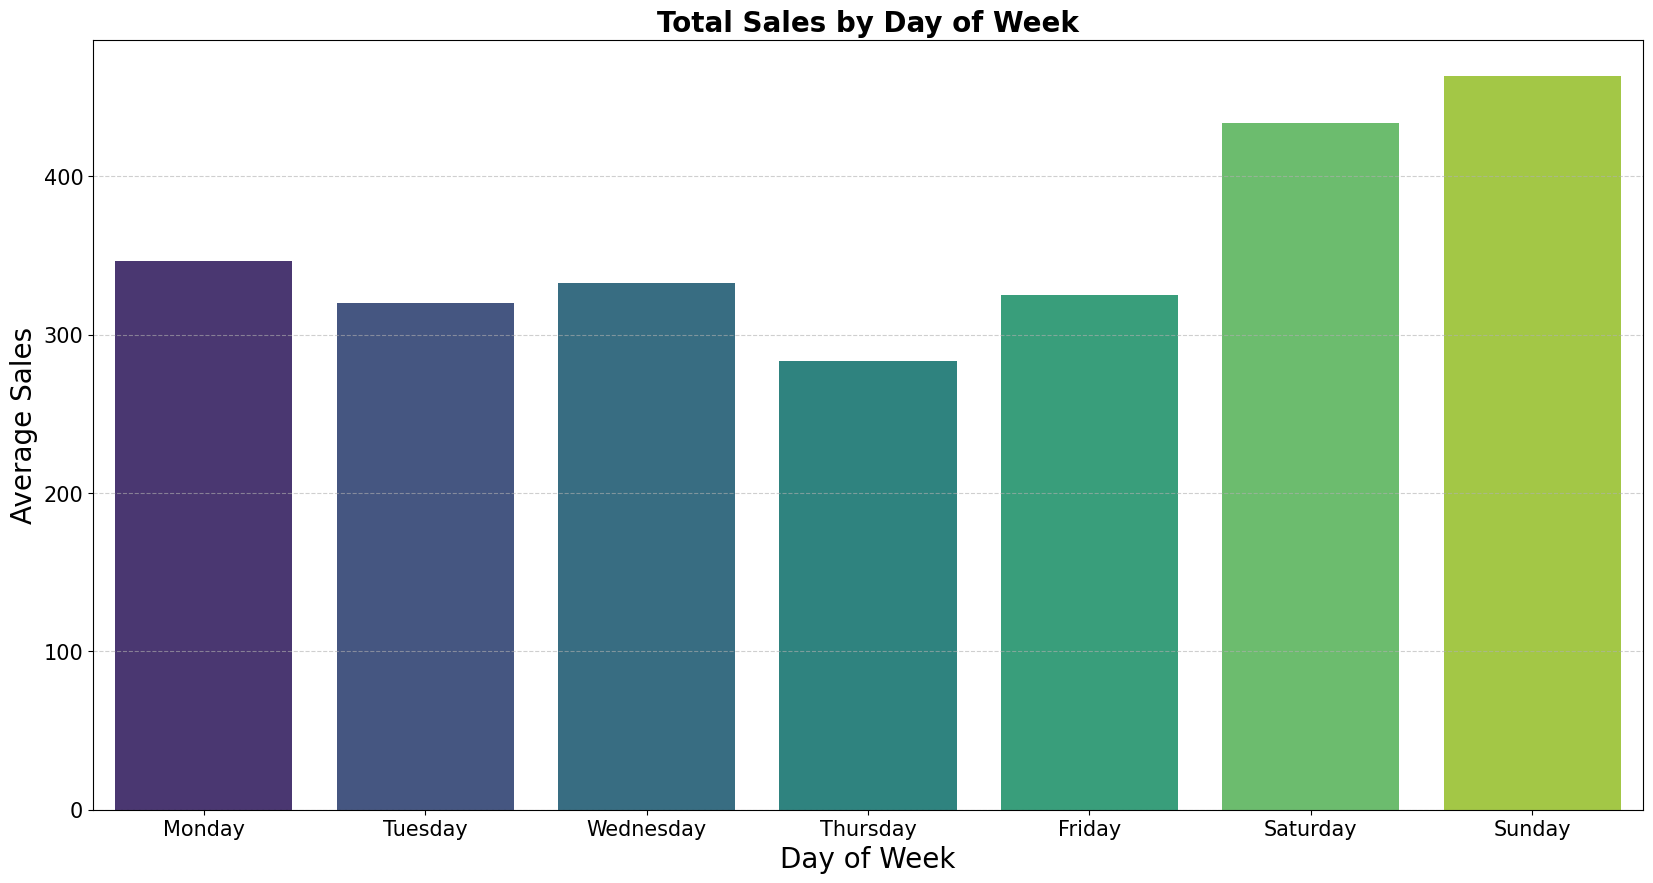

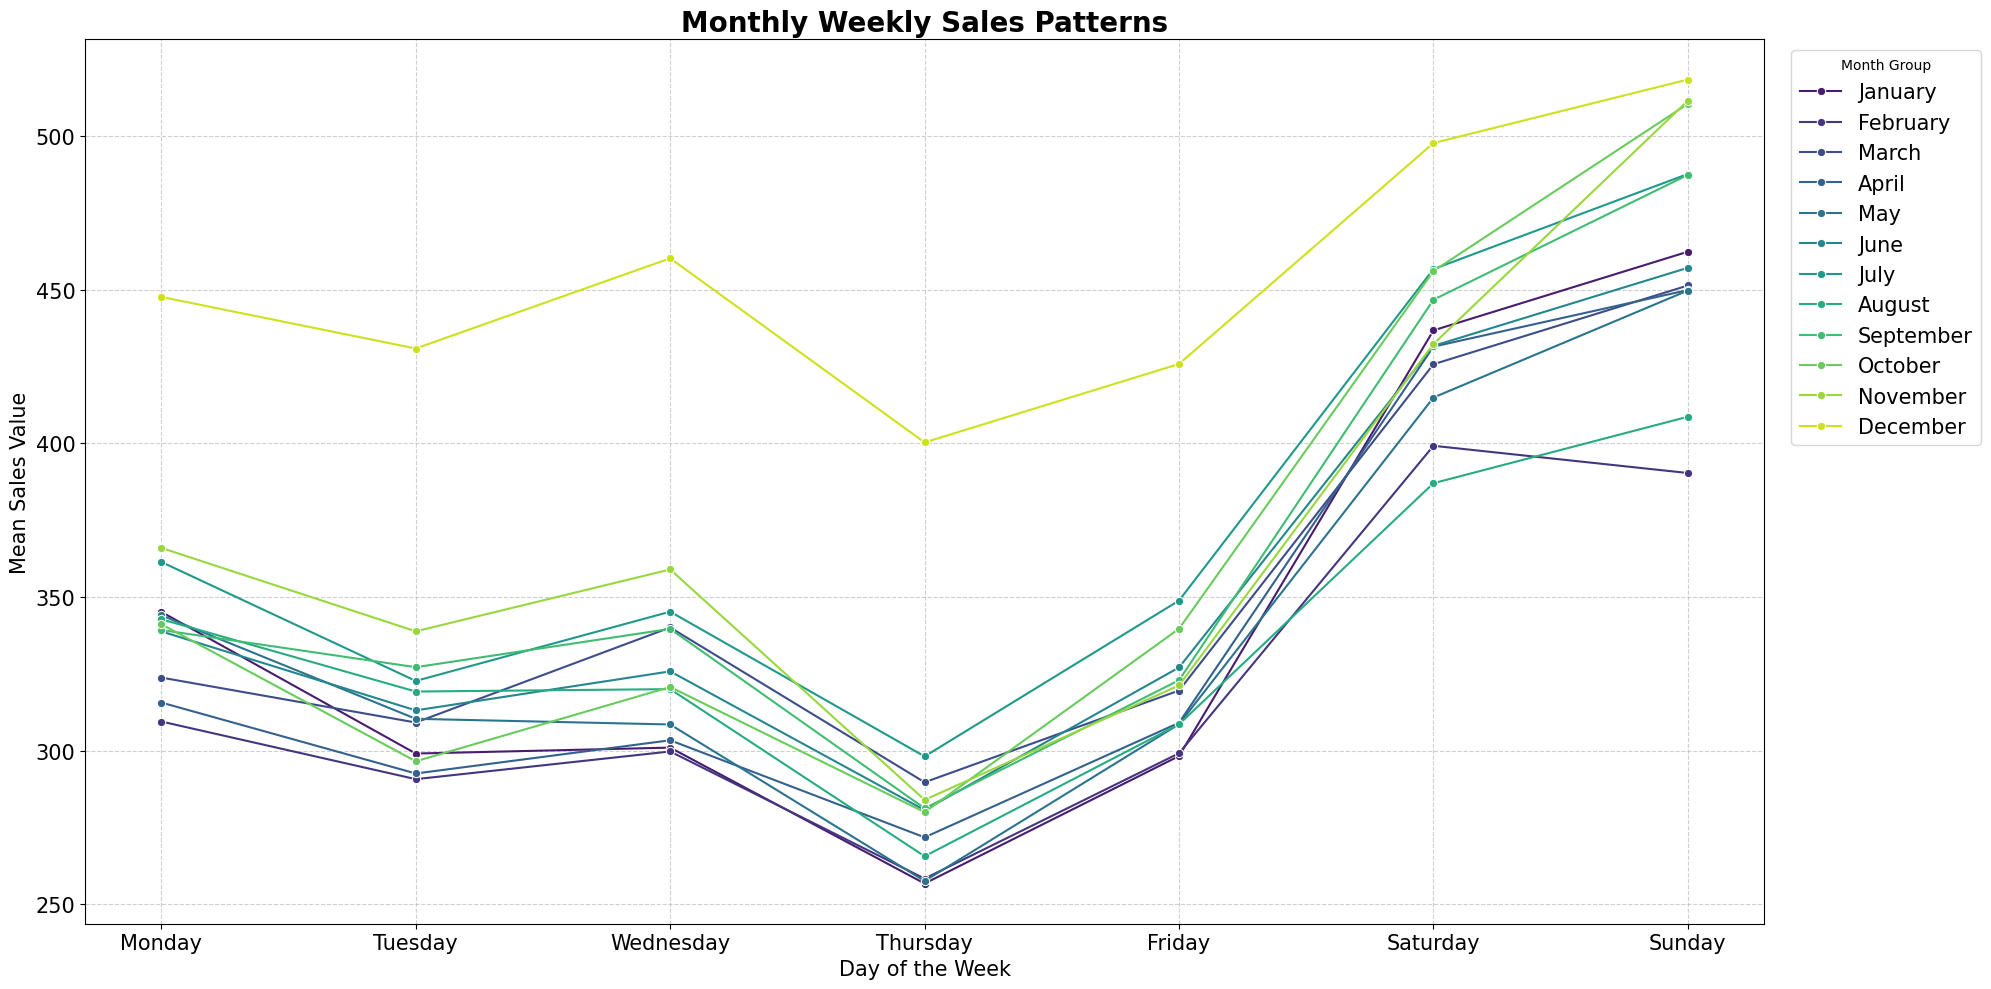

In [16]:
# Weekly dependence
train['day_of_week'] = train.index.dayofweek
train['day_of_month'] = train.index.day
train['month'] = train.index.month

sales_weekly = train.groupby('day_of_week')['sales'].mean()
sales_weekly.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(20, 10))
sns.barplot(x=sales_weekly.index, y=sales_weekly, palette='viridis')
plt.xlabel('Day of Week', fontsize=20)
plt.ylabel('Average Sales', fontsize=20)
plt.xticks(ticks=np.arange(7), labels=sales_weekly.index, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total Sales by Day of Week', fontsize=20, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

weekly_sales = train.groupby(['month', 'day_of_week'])['sales'].mean().reset_index()
weekly_sales['day_of_week'] = weekly_sales['day_of_week'].replace({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})
weekly_sales['month'] = weekly_sales['month'].replace({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

plt.figure(figsize=(20, 10))
sns.lineplot(data=weekly_sales, x='day_of_week', y='sales', hue='month', palette='viridis', marker="o")
plt.title('Monthly Weekly Sales Patterns', fontsize=20, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=15)
plt.ylabel('Mean Sales Value', fontsize=15)
plt.xticks(range(0, 7), fontsize=15)  # Ensuring days are displayed from 0 to 6
plt.yticks(fontsize=15)
plt.legend(title='Month Group', loc='upper left', fontsize=15, bbox_to_anchor=(1.01, 1))

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_4837/2256424599.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_monthly.index, y=sales_monthly, palette='viridis')


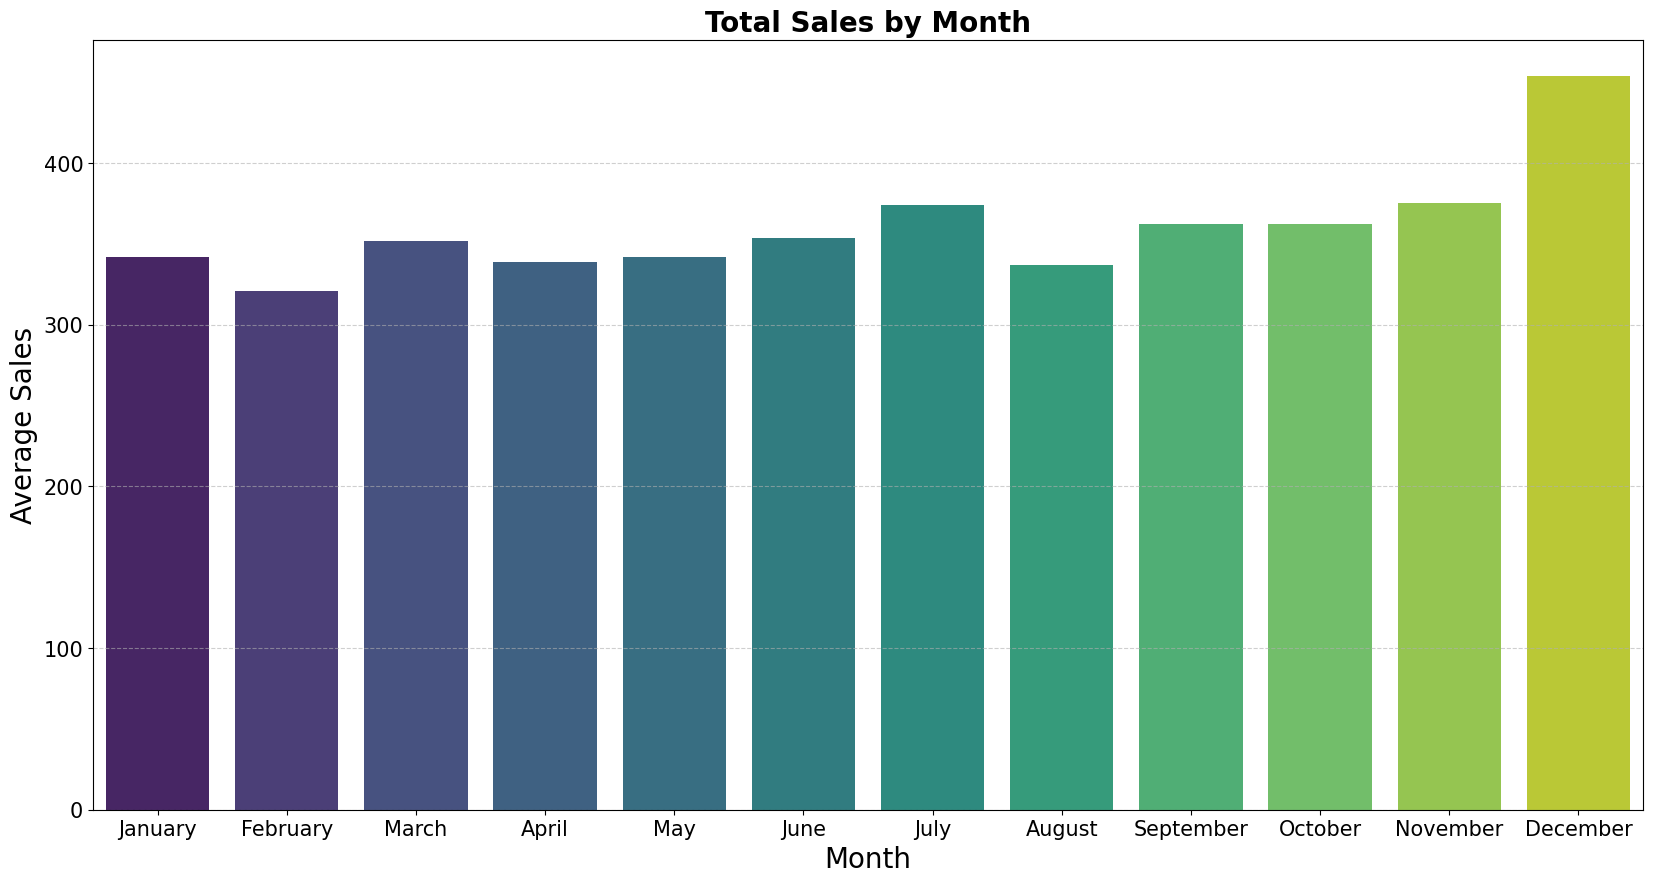

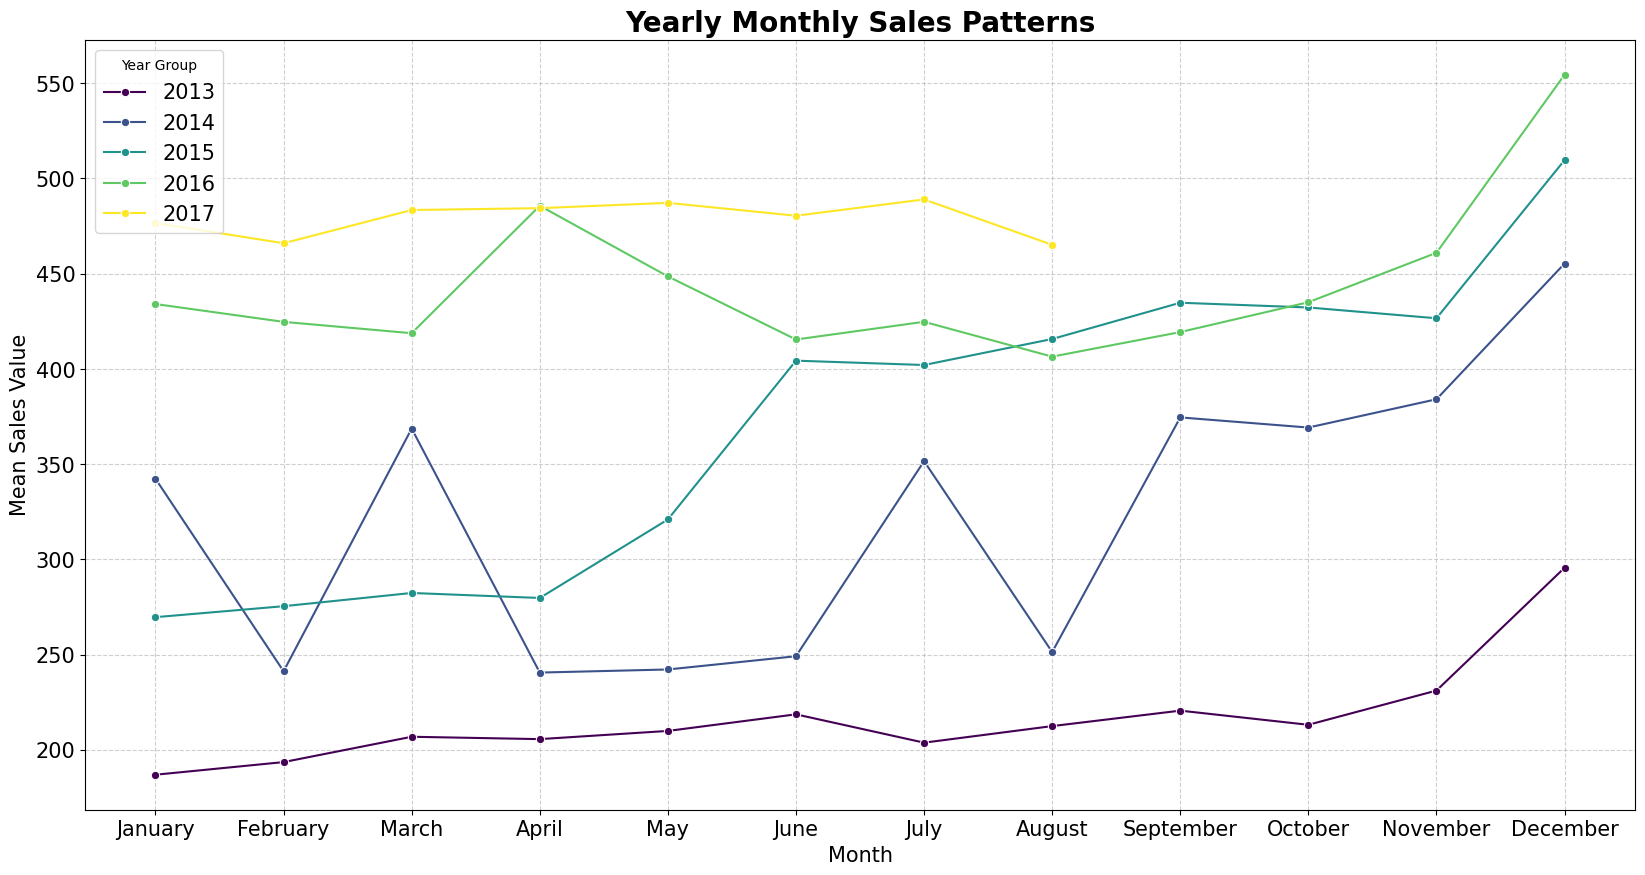

In [17]:
# Monthly dependence
sales_monthly = train.groupby('month')['sales'].mean()
sales_monthly.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(20, 10))
sns.barplot(x=sales_monthly.index, y=sales_monthly, palette='viridis')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Average Sales', fontsize=20)
plt.xticks(ticks=np.arange(12), labels=sales_monthly.index, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total Sales by Month', fontsize=20, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

train['year'] = train.index.year
train['month'] = train.index.month
monthly_sales = train.groupby(['year', 'month'])['sales'].mean().reset_index()
monthly_sales['month'] = monthly_sales['month'].replace({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Plot: Monthly Sales Trends Over Years
plt.figure(figsize=(20, 10))  # Ensure this is correctly set
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette='viridis', marker="o")
plt.title('Yearly Monthly Sales Patterns', fontsize=20, fontweight='bold')
plt.ylabel('Mean Sales Value', fontsize=15)
plt.xlabel('Month', fontsize=15)
plt.xticks(range(0, 12), fontsize=15)  # Ensuring months are displayed from 1 to 12
plt.yticks(fontsize=15)
plt.legend(title='Year Group', loc='upper left', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

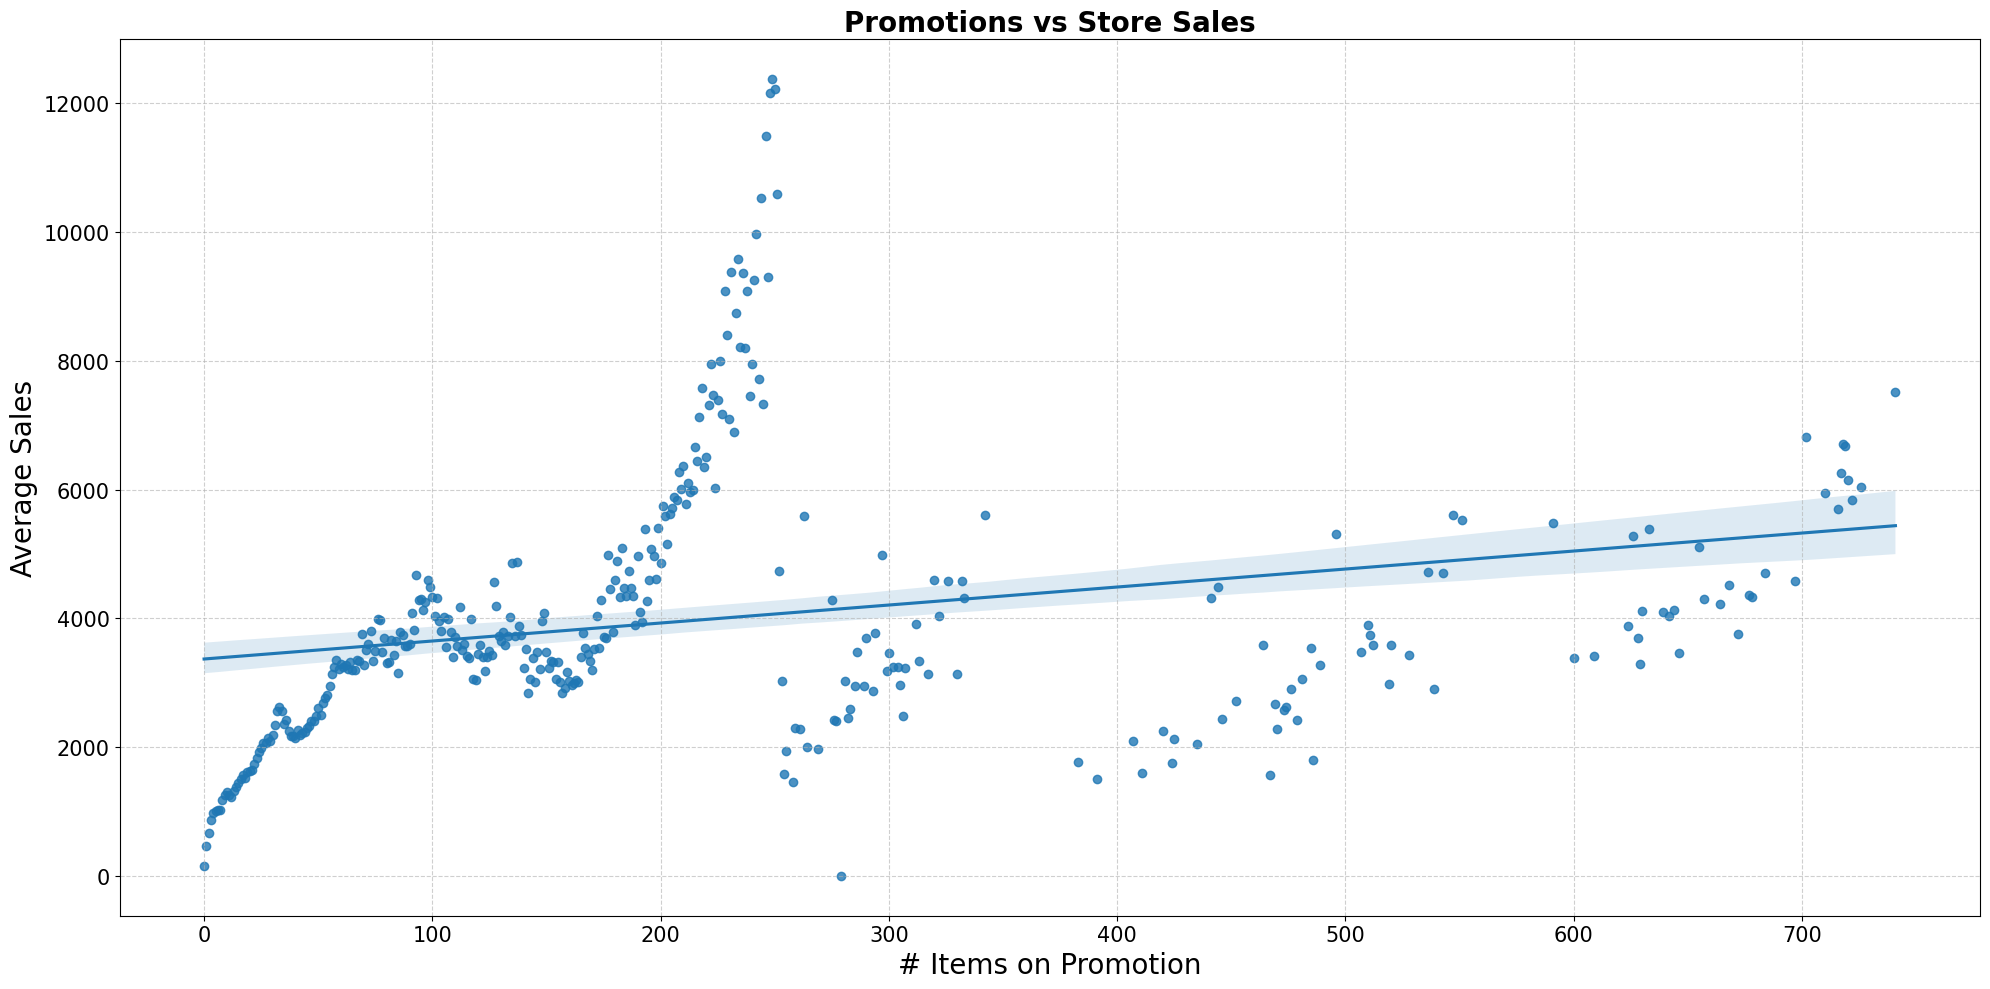

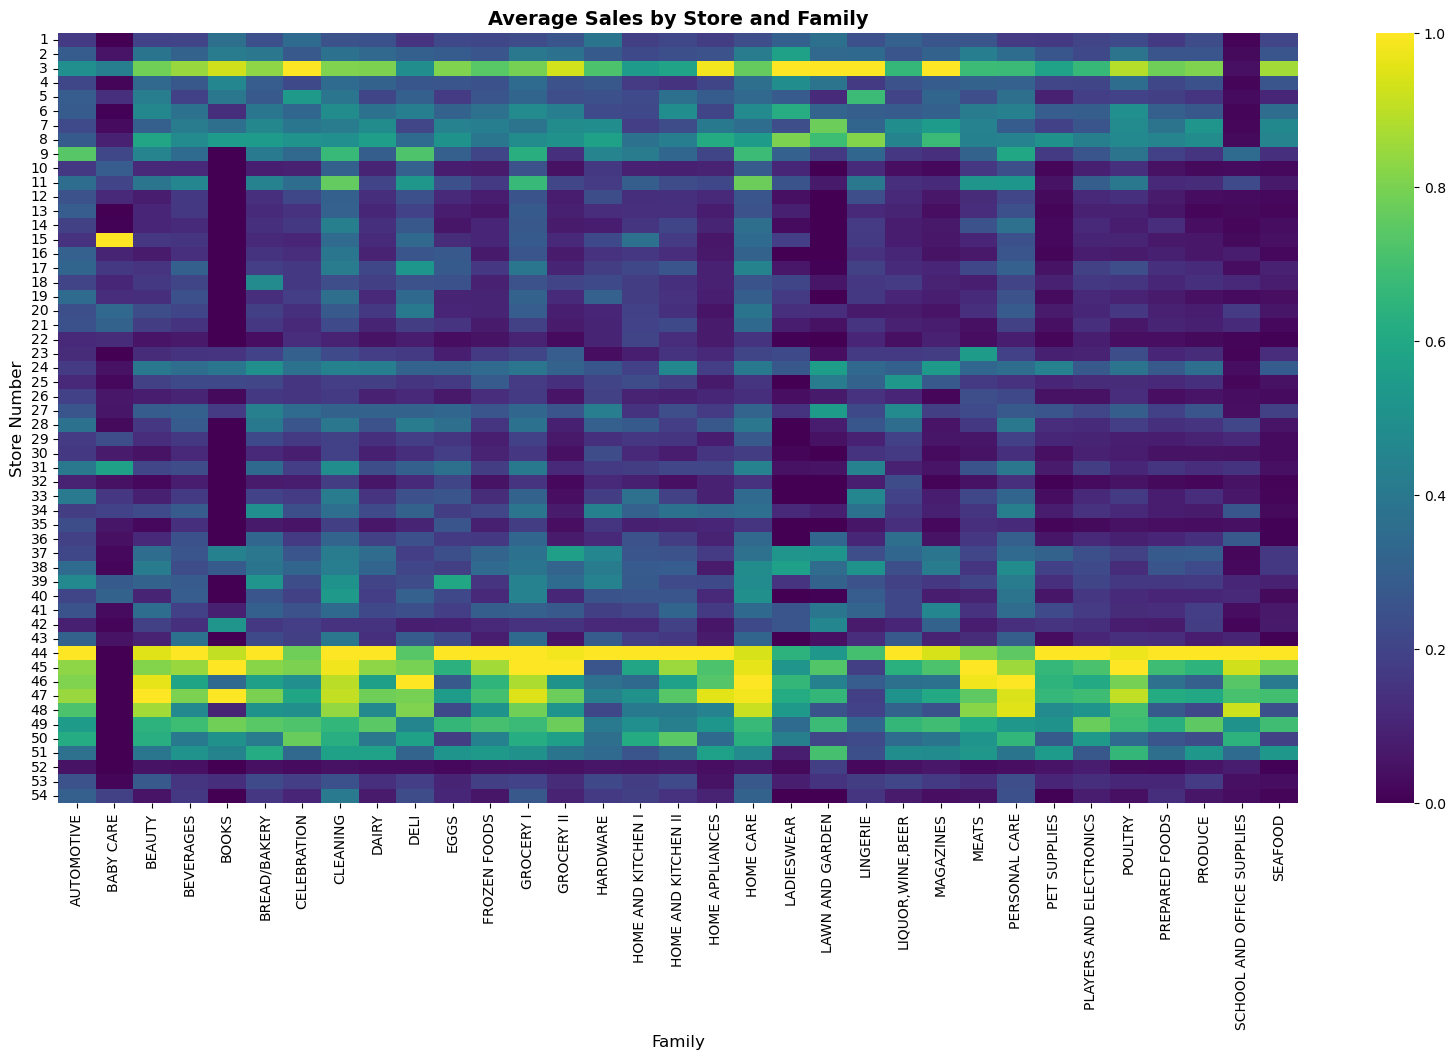

In [18]:
# Sales and promo
data_sales_promo = train.groupby(['onpromotion'], as_index=False)['sales'].mean()
fig, ax = plt.subplots(figsize=(20, 10))
sns.regplot(x=data_sales_promo['onpromotion'], y=data_sales_promo['sales'], ax=ax)
ax.set_ylabel("Average Sales", fontsize=20)
ax.set_xlabel("# Items on Promotion", fontsize=20)
ax.set_title("Promotions vs Store Sales", fontsize=20, fontweight='bold')
ax.tick_params(axis='both', labelsize=15)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Heatmaps of sales and promotions by store and family
check = train.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
check = check.pivot(index='store_nbr', columns='family', values='sales')
check = check.fillna(0)
check = check / check.max()

plt.figure(figsize=(20, 10))
sns.heatmap(check, cmap='viridis')
plt.title('Average Sales by Store and Family', fontsize=14, fontweight='bold')
plt.xlabel('Family', fontsize=12)
plt.ylabel('Store Number', fontsize=12)
plt.show()

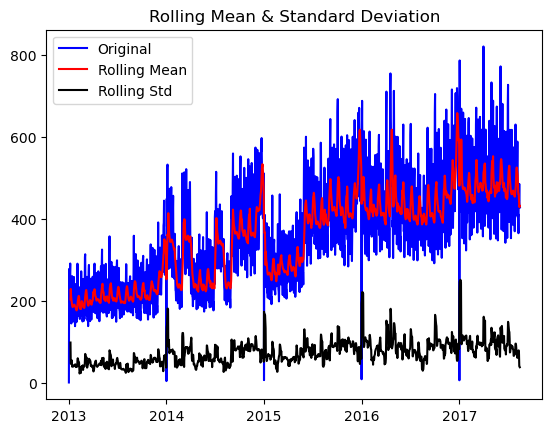

Results of Dickey-Fuller Test:
Test Statistic                   -2.616196
p-value                           0.089696
#Lags Used                       22.000000
Number of Observations Used    1661.000000
Critical Value (1%)              -3.434293
Critical Value (5%)              -2.863282
Critical Value (10%)             -2.567697
dtype: float64


In [19]:
# Test Stationarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


test_stationarity(sales['sales'])

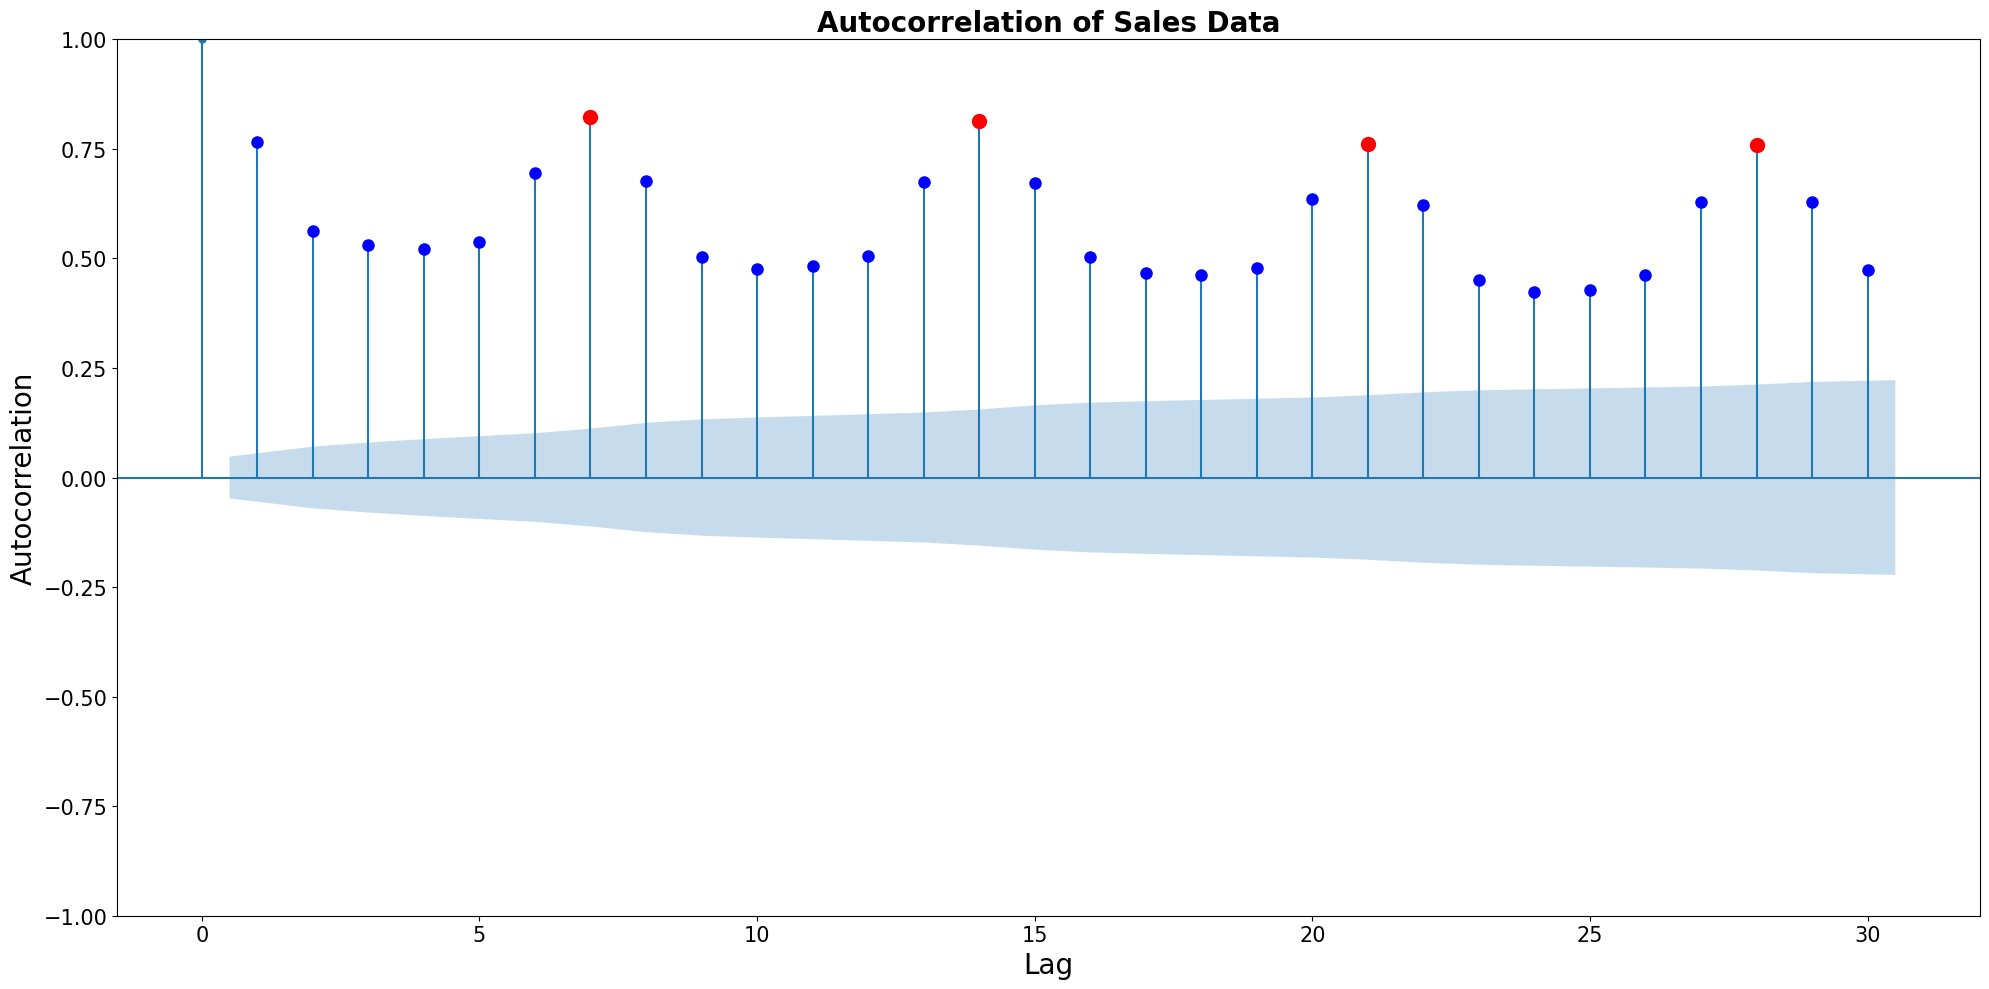

In [20]:
# Autocorrelation of sales
store_train = train[train['store_nbr'] == store]
store_train = train.groupby('date')['sales'].mean()

fig, ax = plt.subplots(figsize=(20, 10))
sm.graphics.tsa.plot_acf(store_train, lags=30, alpha=0.05, ax=ax)
acf_values = sm.tsa.acf(store_train, nlags=30)  
for i in range(1, 31):
    if i % 7 == 0:
        ax.plot(i, acf_values[i], 'ro', markersize=10)  
    else:
        ax.plot(i, acf_values[i], 'bo', markersize=8)  # Altri punti in blu
ax.set_title('Autocorrelation of Sales Data', fontsize=20, fontweight='bold')
ax.set_xlabel('Lag', fontsize=20)
ax.set_ylabel('Autocorrelation', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
# Preprocessing and grouping data by store
train_data = {}
for store in np.sort(train['store_nbr'].unique()):
    store_train = train[train['store_nbr'] == store]
    train_data[store] = {}
    family = pd.DataFrame(index=pd.date_range(start=start_date_train, end=end_date_train, freq='D'))
    for fam in np.sort(store_train['family'].unique()):
        family_train = store_train[store_train['family'] == fam].copy()
        family_train = family_train[['sales', 'onpromotion']]
        family_train.rename(columns={'sales': f'sales_{fam}', 'onpromotion': f'promo_{fam}'}, inplace=True)
        
        family_train['date'] = family_train.index
        dates = pd.to_datetime(family_train['date'])
        full_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')
        missing_days = full_range.difference(dates)
        
        for missing_day in missing_days:
            new_row = pd.DataFrame({
                f'sales_{fam}': [0],
                f'promo_{fam}': [0],
            }, index=[missing_day])
            family_train = pd.concat([family_train, new_row])
        family_train.sort_index(inplace=True)
        family_train.drop('date', axis=1, inplace=True)
        family_train[f'promo_{fam}'] = family_train[f'promo_{fam}'].replace({np.nan: 0})
        family = family.join(family_train)

    family = family.join(oil['dcoilwtico_new'])
    true_holidays_dates = true_holiday.index
    family['holiday'] = family.index.isin(true_holidays_dates).astype(int)
    family.dropna(inplace=True)
    train_data[store] = family

test_data = {}
for store in np.sort(test['store_nbr'].unique()):
    test_store = test[test['store_nbr'] == store]
    test_data[store] = {}
    family = pd.DataFrame(index=pd.date_range(start=start_date_test, end=end_date_test, freq='D'))
    for fam in np.sort(test_store['family'].unique()):
        family_test = test_store[test_store['family'] == fam].copy()
        family_test = family_test[['onpromotion']]
        family_test.rename(columns={'onpromotion': f'promo_{fam}'}, inplace=True)
        
        family_test['date'] = family_test.index
        dates = pd.to_datetime(family_test['date'])
        full_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')
        missing_days = full_range.difference(dates)
        
        for missing_day in missing_days:
            new_row = pd.DataFrame({
                f'promo_{fam}': [0],
            }, index=[missing_day])
            family_test = pd.concat([family_test, new_row])
        family_test.sort_index(inplace=True)
        family_test.drop('date', axis=1, inplace=True)
        family_test[f'promo_{fam}'] = family_test[f'promo_{fam}'].replace({np.nan: 0})
        family = family.join(family_test)
    
    family = family.join(oil['dcoilwtico_new'])
    true_holidays_dates = true_holiday.index
    family['holiday'] = family.index.isin(true_holidays_dates).astype(int)
    family.dropna(inplace=True)
    test_data[store] = family

train_data = {int(k): v for k, v in train_data.items()}
test_data = {int(k): v for k, v in test_data.items()}

# Saving data
if not os.path.exists(root_dir + '/preprocessed_data'):
    os.makedirs(root_dir + '/preprocessed_data')
with open(root_dir + '/preprocessed_data/train_data_store.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open(root_dir + '/preprocessed_data/test_data_store.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [ ]:
# Preprocessing and grouping data by family
train_data_family = {}
for fam in np.sort(train['family'].unique()):
    family_train = train[train['family'] == fam].copy()
    train_data_family[fam] = {}
    df_store = pd.DataFrame(index=pd.date_range(start=start_date_train, end=end_date_train, freq='D'))
    for store in np.sort(family_train['store_nbr'].unique()):
        store_train = family_train[family_train['store_nbr'] == store]
        store_train = store_train[['sales', 'onpromotion']]
        store_train.rename(columns={'sales': f'sales_{store}', 'onpromotion': f'promo_{store}'}, inplace=True)
        
        store_train['date'] = store_train.index
        dates = pd.to_datetime(store_train['date'])
        full_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')
        missing_days = full_range.difference(dates)
        
        for missing_day in missing_days:
            new_row = pd.DataFrame({
                f'sales_{store}': [0],
                f'promo_{store}': [0],
            }, index=[missing_day])
            store_train = pd.concat([store_train, new_row])
        store_train.sort_index(inplace=True)
        store_train.drop('date', axis=1, inplace=True)
        store_train[f'promo_{store}'] = store_train[f'promo_{store}'].replace({np.nan: 0})
        df_store = df_store.join(store_train)
    
    df_store = df_store.join(oil['dcoilwtico_new'])
    true_holidays_dates = true_holiday.index
    df_store['holiday'] = df_store.index.isin(true_holidays_dates).astype(int)
    df_store.dropna(inplace=True)
    train_data_family[fam] = df_store

test_data_family = {}
for fam in np.sort(test['family'].unique()):
    family_test = test[test['family'] == fam].copy()
    test_data_family[fam] = {}
    df_store = pd.DataFrame(index=pd.date_range(start=start_date_test, end=end_date_test, freq='D'))
    for store in np.sort(family_test['store_nbr'].unique()):
        store_test = family_test[family_test['store_nbr'] == store]
        store_test = store_test[['onpromotion']]
        store_test.rename(columns={'onpromotion': f'promo_{store}'}, inplace=True)
        
        store_test['date'] = store_test.index
        dates = pd.to_datetime(store_test['date'])
        full_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')
        missing_days = full_range.difference(dates)
        
        for missing_day in missing_days:
            new_row = pd.DataFrame({
                f'promo_{store}': [0],
            }, index=[missing_day])
            store_test = pd.concat([store_test, new_row])
        store_test.sort_index(inplace=True)
        store_test.drop('date', axis=1, inplace=True)
        store_test[f'promo_{store}'] = store_test[f'promo_{store}'].replace({np.nan: 0})
        df_store = df_store.join(store_test)
    
    df_store = df_store.join(oil['dcoilwtico_new'])
    true_holidays_dates = true_holiday.index
    df_store['holiday'] = df_store.index.isin(true_holidays_dates).astype(int)
    df_store.dropna(inplace=True)
    test_data_family[fam] = df_store

train_data_family = {str(k): v for k, v in train_data_family.items()}
test_data_family = {str(k): v for k, v in test_data_family.items()}

# Saving data
if not os.path.exists(root_dir + '/preprocessed_data'):
    os.makedirs(root_dir + '/preprocessed_data')
with open(root_dir + '/preprocessed_data/train_data_family.pkl', 'wb') as f:
    pickle.dump(train_data_family, f)
with open(root_dir + '/preprocessed_data/test_data_family.pkl', 'wb') as f:
    pickle.dump(test_data_family, f)